# Correlation and test of relationship

In this notebook, we briefly show how to visualize and test for correlation between two variables.

First we import the standard packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

Then we import some example data. In this case Google Analytics webdata about daily users and daily number of purchases in the webshop

In [2]:
webdata = pd.read_excel("GA users and convertions.xlsx")

In [3]:
webdata

,DayIndex,Users,PurchaseCompleted
0,2016-08-01,560,8
1,2016-08-02,378,10
2,2016-08-03,412,11
3,2016-08-04,499,7
4,2016-08-05,375,11
...,...,...,...
87,2016-10-27,351,23
88,2016-10-28,398,23
89,2016-10-29,209,10
90,2016-10-30,224,16


## Visualizing correlation between two numeric variables

Thus visualize the correlation between two numeric variables, we use a scatterplot.

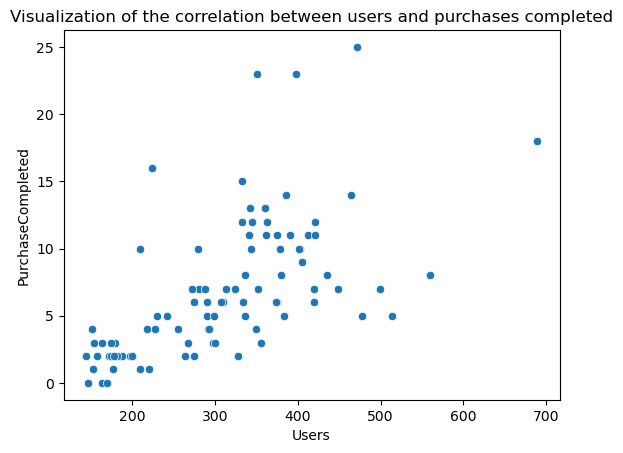

In [4]:
sns.scatterplot(data = webdata, x = "Users", y = "PurchaseCompleted")
plt.title("Visualization of the correlation between users and purchases completed")
plt.savefig('corrplot.png')
plt.show()

## Correlation coefficient

To calculate the (Pearson) correlation coefficient between two numeric variables we can either use the `.corr` method in pandas or the `pearsonr` from SciPy.

In [5]:
webdata["Users"].corr(webdata["PurchaseCompleted"])

np.float64(0.6152012891837794)

In [6]:
stats.pearsonr(webdata["Users"], webdata["PurchaseCompleted"])

PearsonRResult(statistic=np.float64(0.6152012891837795), pvalue=np.float64(6.80560196187495e-11))

Note that, with `pearsonr` from SciPy we also get a p-value indicating whether the correlation coefficient is significantly different from 0.

## Relationship between a numeric and a categorical variable

To visualize the relationship, one can either do a histogram for each value of the categorical or boxplot.

We will use the adult dataset af example

In [7]:
from ucimlrepo import fetch_ucirepo 
  
adult_temp = fetch_ucirepo(id=2) 
  
X = adult_temp.data.features 
y = adult_temp.data.targets 
X["income"] = y
adult = X

adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


We look at the relationship between *sex* and *hours-per-week*. We can do both histograms and boxplots.

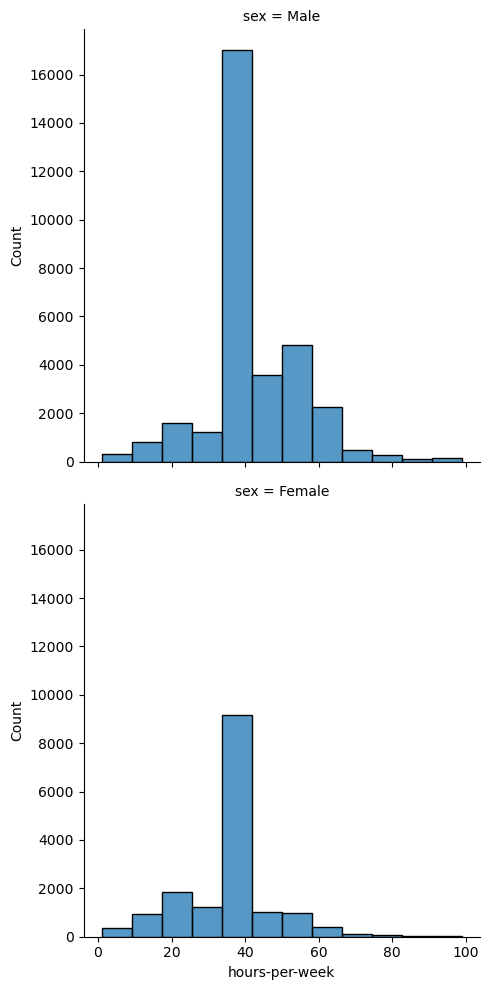

In [8]:
g=sns.FacetGrid(data = adult, row="sex", height = 5)
g.map(sns.histplot, "hours-per-week", bins = 12)
plt.show()

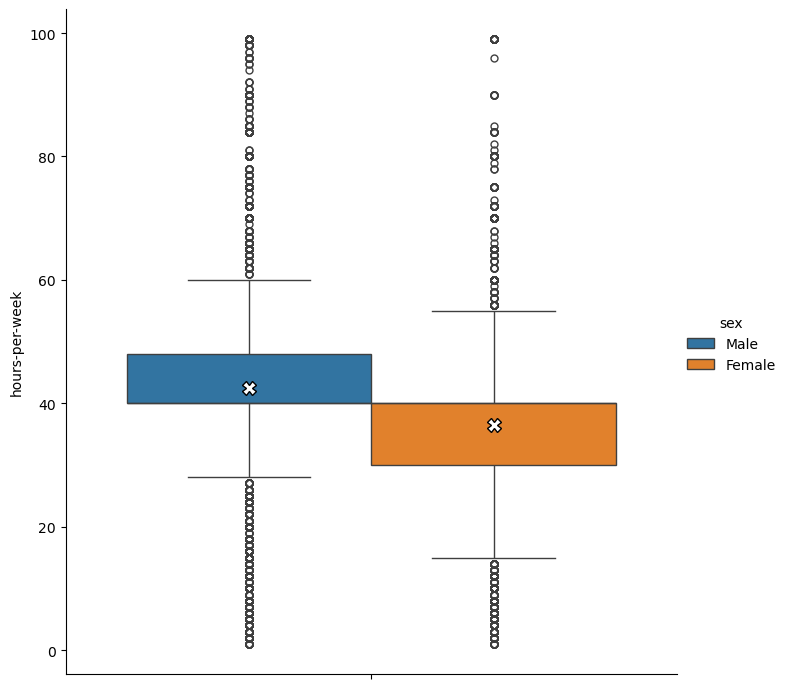

In [9]:
sns.catplot(y="hours-per-week", hue = "sex", data = adult, kind="box", height = 7,
            showmeans=True,
            meanprops={"marker":"X", "markerfacecolor":"white", "markeredgecolor":"black", "markersize": "10"})
plt.show()

To test if the difference in hours-per-week is significant, we can use the tests from the statistics class such as the Sudent t-test or Mann-Whitney U test.

In [10]:
stats.ttest_ind(adult[adult["sex"]=="Female"]["hours-per-week"], adult[adult["sex"]=="Male"]["hours-per-week"])

TtestResult(statistic=np.float64(-51.88459005806161), pvalue=np.float64(0.0), df=np.float64(48840.0))

In [11]:
stats.mannwhitneyu(adult[adult["sex"]=="Female"]["hours-per-week"], adult[adult["sex"]=="Male"]["hours-per-week"])

MannwhitneyuResult(statistic=np.float64(183232044.5), pvalue=np.float64(0.0))

## Relationship between two categorical variables

We will now look at the relationship between *sex* and *income*. 

For visualizing the relationship, we can use a mosaic plot.

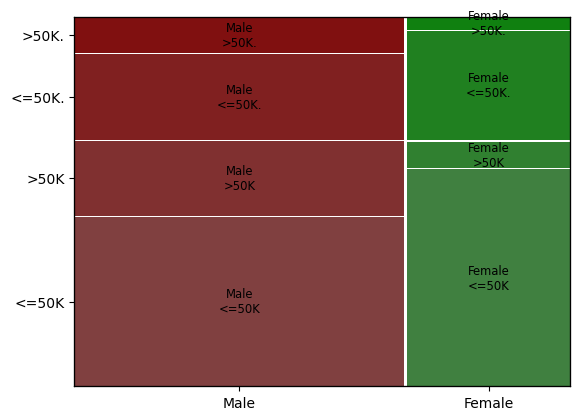

In [12]:
from statsmodels.graphics.mosaicplot import mosaic

mosaic(adult, ["sex", "income"])
plt.show()

It seems that there is something strange with the *income* variable...

In [13]:
adult["income"].groupby(adult["income"]).count()

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: income, dtype: int64

It seems like there are "<=50k." that should be "<=50k" and ">50k." that should be ">50k". Thus we can fix it by just replacing "." with nothing in the *income* column.

In [14]:
adult['income'] = adult['income'].str.replace('.','')

In [15]:
adult["income"].groupby(adult["income"]).count()

income
<=50K    37155
>50K     11687
Name: income, dtype: int64

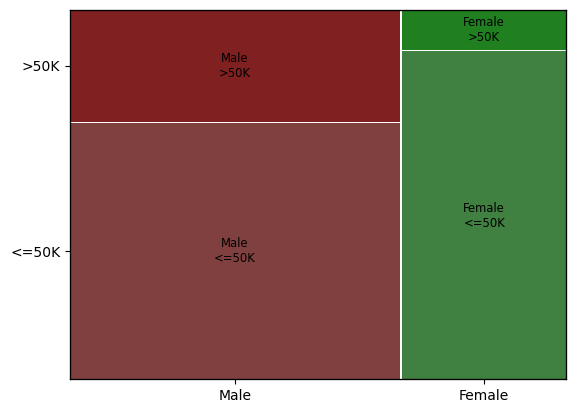

In [16]:
mosaic(adult, ["sex", "income"])
plt.show()

We can get the numbers of each combined group by the pandas cross table

In [17]:
pd.crosstab(adult["sex"], adult["income"])

income,<=50K,>50K
sex,,
Female,14423,1769
Male,22732,9918


Since there are plenty of individuals in all combined groups, we can use the Chi-squared test to test for whether there is a statistically significant relationship between the two categorical variables. (If there were a combined group with less than 5 individuals, one should use the Fisher's Exact test instead.)

In [18]:
stats.chi2_contingency(pd.crosstab(adult["sex"], adult["income"]))

Chi2ContingencyResult(statistic=np.float64(2248.847679013691), pvalue=np.float64(0.0), dof=1, expected_freq=array([[12317.54964989,  3874.45035011],
       [24837.45035011,  7812.54964989]]))

As the p-value is well below our significance level of 0.05, we reject the null hypothesis that there is no relationship between the two groups. Thus, we have statistical significant support for there being a diffence in income across different genders.